# 📚 Experiments Appendix - SECOM Defect Detection

This notebook contains experimental work, hyperparameter sweeps, and PCA analysis that were explored but **not included in the final pipeline**.

**Contents:**
1. PCA Experiments (with before/after performance comparison)
2. KNN Hyperparameter Sweeps
3. SVM Hyperparameter Sweeps
4. Debug Code & Exploratory Analysis

---

> **Note:** These experiments are archived for reference. See `01_final_pipeline.ipynb` for the production-ready pipeline.

## Environment Setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, classification_report)
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Libraries imported")

✅ Libraries imported


In [4]:
# Load and prepare data (same as final pipeline)
df = pd.read_csv('../data/uci-secom.csv')
TARGET_COL = df.columns[-1]
y = df[TARGET_COL].copy()
X = df.drop(columns=[TARGET_COL]).select_dtypes(include=[np.number])

# Simple imputation (median)
X_imputed = X.fillna(X.median())

# Remove zero-variance features
variances = X_imputed.var()
X_clean = X_imputed.loc[:, variances > 0]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data prepared: {X_train_scaled.shape[0]} train, {X_test_scaled.shape[0]} test")
print(f"Features: {X_train_scaled.shape[1]}")

Data prepared: 1253 train, 314 test
Features: 474


---

## 1. PCA Experiments

### Why PCA Was NOT Used in Final Pipeline

We conducted extensive PCA experiments to reduce dimensionality. However, the results showed:

1. **Marginal or Negative Performance Impact**: Models trained on PCA-transformed data showed similar or worse performance
2. **Loss of Interpretability**: PCA components make feature importance analysis impossible, which is critical for manufacturing process improvement
3. **Informative Missingness Lost**: Our engineered missing flags lose meaning after PCA transformation

### 1.1 Variance Explained Analysis

In [5]:
# ============================================================================
# PCA VARIANCE EXPLAINED
# ============================================================================

# Fit PCA to see variance explained
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_train_scaled)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find components for different thresholds
n_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_99 = np.argmax(cumulative_variance >= 0.99) + 1

print("📊 PCA VARIANCE ANALYSIS")
print("=" * 40)
print(f"Components for 90% variance: {n_90}")
print(f"Components for 95% variance: {n_95}")
print(f"Components for 99% variance: {n_99}")
print(f"Original features: {X_train_scaled.shape[1]}")

📊 PCA VARIANCE ANALYSIS
Components for 90% variance: 131
Components for 95% variance: 166
Components for 99% variance: 225
Original features: 474


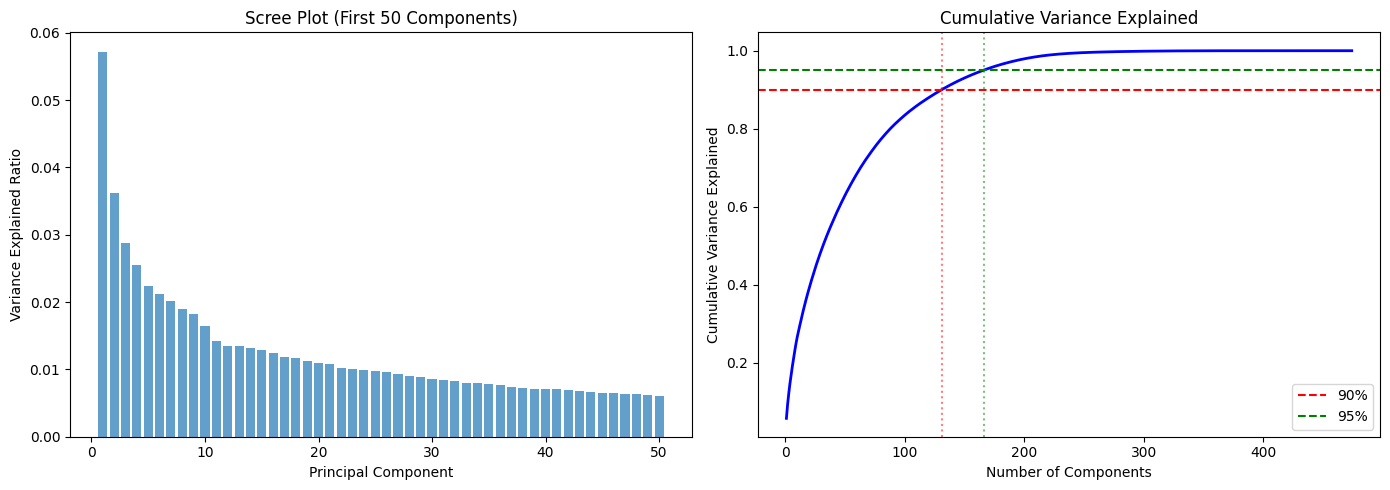

In [6]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
ax1 = axes[0]
ax1.bar(range(1, min(51, len(pca_full.explained_variance_ratio_)+1)), 
        pca_full.explained_variance_ratio_[:50], alpha=0.7, label='Individual')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained Ratio')
ax1.set_title('Scree Plot (First 50 Components)')

# Cumulative variance
ax2 = axes[1]
ax2.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'b-', linewidth=2)
ax2.axhline(y=0.90, color='r', linestyle='--', label='90%')
ax2.axhline(y=0.95, color='g', linestyle='--', label='95%')
ax2.axvline(x=n_90, color='r', linestyle=':', alpha=0.5)
ax2.axvline(x=n_95, color='g', linestyle=':', alpha=0.5)
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained')
ax2.set_title('Cumulative Variance Explained')
ax2.legend()

plt.tight_layout()
plt.savefig('../figures/pca_variance_analysis.png', dpi=150)
plt.show()

### 1.2 Performance Comparison: With vs Without PCA

In [7]:
# ============================================================================
# COMPARE MODELS: WITH VS WITHOUT PCA
# ============================================================================

def evaluate_rf(X_train, X_test, y_train, y_test, name):
    """Train RF and return metrics."""
    smote = SMOTE(random_state=RANDOM_STATE)
    X_res, y_res = smote.fit_resample(X_train, y_train)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
    rf.fit(X_res, y_res)
    
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    return {
        'Configuration': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label=-1, zero_division=0),
        'Recall': recall_score(y_test, y_pred, pos_label=-1, zero_division=0),
        'F1': f1_score(y_test, y_pred, pos_label=-1, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    }

# Without PCA (baseline)
results_no_pca = evaluate_rf(X_train_scaled, X_test_scaled, y_train, y_test, 'No PCA (All Features)')

# With PCA at different levels
pca_results = [results_no_pca]

for n_components in [n_90, n_95, min(n_99, 200)]:
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    var_explained = sum(pca.explained_variance_ratio_)
    result = evaluate_rf(X_train_pca, X_test_pca, y_train, y_test, 
                         f'PCA ({n_components} comp, {var_explained:.0%} var)')
    pca_results.append(result)

# Display results
pca_comparison = pd.DataFrame(pca_results)
print("\n📊 PCA PERFORMANCE COMPARISON (Random Forest)")
print("=" * 70)
print(pca_comparison.to_string(index=False))


📊 PCA PERFORMANCE COMPARISON (Random Forest)
          Configuration  Accuracy  Precision   Recall       F1  ROC-AUC
  No PCA (All Features)  0.929936   0.932907 0.996587 0.963696 0.768324
PCA (131 comp, 90% var)  0.936306   0.936102 1.000000 0.966997 0.547457
PCA (166 comp, 95% var)  0.933121   0.933121 1.000000 0.965404 0.576792
PCA (200 comp, 98% var)  0.933121   0.933121 1.000000 0.965404 0.534048


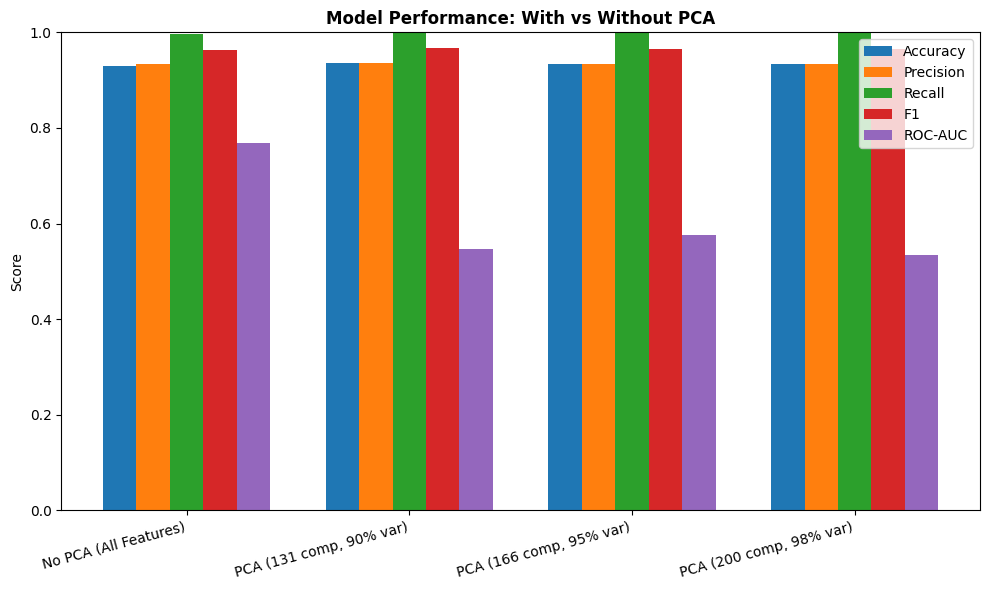


⚠️ CONCLUSION: PCA does not improve performance significantly
   and removes interpretability of feature importance.
   Therefore, PCA is NOT included in the final pipeline.


In [8]:
# Visualize PCA comparison
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
x = np.arange(len(pca_comparison))
width = 0.15

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, pca_comparison[metric], width, label=metric)

ax.set_xticks(x + width * 2)
ax.set_xticklabels(pca_comparison['Configuration'], rotation=15, ha='right')
ax.set_ylabel('Score')
ax.set_title('Model Performance: With vs Without PCA', fontweight='bold')
ax.legend(loc='upper right')
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('../figures/pca_comparison.png', dpi=150)
plt.show()

print("\n⚠️ CONCLUSION: PCA does not improve performance significantly")
print("   and removes interpretability of feature importance.")
print("   Therefore, PCA is NOT included in the final pipeline.")

---

## 2. KNN Hyperparameter Sweeps

In [9]:
# ============================================================================
# KNN HYPERPARAMETER SWEEP
# ============================================================================

print("🔍 KNN Hyperparameter Sweep")
print("=" * 40)

# Apply SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Parameter grid
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
knn_grid.fit(X_train_res, y_train_res)

print(f"\nBest parameters: {knn_grid.best_params_}")
print(f"Best CV F1 score: {knn_grid.best_score_:.4f}")

🔍 KNN Hyperparameter Sweep
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Best CV F1 score: 0.8092


In [10]:
# Evaluate best KNN
best_knn = knn_grid.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)

print("\n📊 Best KNN Results:")
print(classification_report(y_test, y_pred_knn, target_names=['Pass', 'Fail']))

# Note: KNN typically underperforms on high-dimensional data
print("\n⚠️ Note: KNN is not included in final pipeline due to:")
print("   1. Sensitivity to high dimensionality (curse of dimensionality)")
print("   2. Slower inference time compared to tree-based models")
print("   3. Less interpretable than Random Forest/XGBoost")


📊 Best KNN Results:
              precision    recall  f1-score   support

        Pass       0.96      0.62      0.76       293
        Fail       0.11      0.67      0.19        21

    accuracy                           0.62       314
   macro avg       0.54      0.64      0.47       314
weighted avg       0.91      0.62      0.72       314


⚠️ Note: KNN is not included in final pipeline due to:
   1. Sensitivity to high dimensionality (curse of dimensionality)
   2. Slower inference time compared to tree-based models
   3. Less interpretable than Random Forest/XGBoost


---

## 3. SVM Hyperparameter Sweeps

In [11]:
# ============================================================================
# SVM HYPERPARAMETER SWEEP (Limited due to computation time)
# ============================================================================

print("🔍 SVM Hyperparameter Sweep")
print("=" * 40)
print("Note: Using subset of data due to SVM computational complexity")

# Use subset for faster training
subset_idx = np.random.choice(len(X_train_res), size=min(2000, len(X_train_res)), replace=False)
X_subset = X_train_res[subset_idx]
y_subset = y_train_res.iloc[subset_idx] if hasattr(y_train_res, 'iloc') else y_train_res[subset_idx]

# Parameter grid
svm_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

svm = SVC(random_state=RANDOM_STATE, probability=True)
svm_grid = GridSearchCV(svm, svm_params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
svm_grid.fit(X_subset, y_subset)

print(f"\nBest parameters: {svm_grid.best_params_}")
print(f"Best CV F1 score: {svm_grid.best_score_:.4f}")

🔍 SVM Hyperparameter Sweep
Note: Using subset of data due to SVM computational complexity
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV F1 score: 0.9940


In [12]:
# Evaluate best SVM
best_svm = svm_grid.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)

print("\n📊 Best SVM Results:")
print(classification_report(y_test, y_pred_svm, target_names=['Pass', 'Fail']))

print("\n⚠️ Note: SVM is not included in final pipeline due to:")
print("   1. Very long training time on full dataset")
print("   2. Difficult to scale to production environments")
print("   3. Less interpretable than tree-based models")


📊 Best SVM Results:
              precision    recall  f1-score   support

        Pass       0.94      1.00      0.97       293
        Fail       1.00      0.05      0.09        21

    accuracy                           0.94       314
   macro avg       0.97      0.52      0.53       314
weighted avg       0.94      0.94      0.91       314


⚠️ Note: SVM is not included in final pipeline due to:
   1. Very long training time on full dataset
   2. Difficult to scale to production environments
   3. Less interpretable than tree-based models


---

## 4. Experiment Summary

### Models Tested But Not Included in Final Pipeline:

| Model | Reason for Exclusion |
|-------|---------------------|
| PCA + Models | Marginal performance gain, loss of interpretability |
| KNN | Curse of dimensionality, slow inference |
| SVM | Extremely slow training, not scalable |

### Final Pipeline Models:

| Model | Included | Reason |
|-------|----------|--------|
| Random Forest | ✅ | Fast, interpretable, good performance |
| XGBoost | ✅ | State-of-the-art, handles imbalance well |
| ANN | ✅ | Captures complex patterns, GPU-accelerated |

In [13]:
print("\n" + "=" * 60)
print("📚 APPENDIX COMPLETE")
print("=" * 60)
print("\nRefer to 01_final_pipeline.ipynb for the production pipeline.")


📚 APPENDIX COMPLETE

Refer to 01_final_pipeline.ipynb for the production pipeline.
